<a href="https://colab.research.google.com/github/scottthomaswx/RAP-Analysis/blob/main/RAPAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Needed Packages

In [3]:
# @title
%%capture
!pip install siphon
!pip install xarray
!pip install metpy
!pip install matplotlib
!pip install numpy
!pip install cartopy
!pip install warnings
!pip install netCDF4
#Import Packages
from siphon.catalog import TDSCatalog
import xarray as xr
import metpy
from metpy.units import units
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from metpy.plots import ctables
import netCDF4
from metpy.plots import USCOUNTIES

#Input Requested Parameters

In [39]:
year = "2023" # @param {type:"string"}
month = "12" # @param {type:"string"}
day = "12" # @param {type:"string"}
hour_utc = "02" # @param {type:"string"}
WestLong = -90 # @param {type:"number"}
EastLong = -80 # @param {type:"number"}
NorthLat = 40.5 # @param {type:"number"}
SouthLat = 45.5 # @param {type:"number"}
timetype = 'Realtime' # @param ["Realtime", "Archive"]

## Evaluate Data Sources To See Where Requested RAP/RUC Data is Located (Only Run Once Per Date-Time)
#Dataset Order
 1. UCAR Archive (Includes Realtime)
 2.  NCEI Operational Archive
 3.  NCEI Non-Operational Archive
 4.  NCEI RUC Archive








In [40]:
# @title
#Pull Rap Data For Case/Selected Time/Date And Open Dataset

#Dataset Order
#Realtime/Past 3 Days -> UCAR Archive
#NCEI Operational Archive
#NCEI Non-Operational Archive
#NCEI RUC Archive
if timetype == 'Archive':
  try:
    tds_RAP = TDSCatalog(f'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/RR_CONUS_13km_{year}{month}{day}_{hour_utc}00.grib2/catalog.html')
    rap_ds=tds_RAP.datasets[0]
    ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
    ds=ds.isel(time=0, time1=0)
    print('Using UCAR Dataset')
  except:
    try:
      tds_RAP=TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/{year}{month}/{year}{month}{day}/catalog.html?dataset=rap130anl/{year}{month}/{year}{month}{day}/rap_130_{year}{month}{day}_{hour_utc}00_001.grb2')
      rap_ds=tds_RAP.datasets[0]
      ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
      ds=ds.isel(time=0, time1=0)
      print('Using NCEI Operational Archive')
    except:
      try:
        tds_rap = TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/{year}{month}/{year}{month}{day}/catalog.html?dataset=rap130anl-old/{year}{month}/{year}{month}{day}/rap_130_{year}{month}{day}_{hour_utc}00_001.grb2')
        rap_ds=tds_RAP.datasets[0]
        ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
        ds=ds.isel(time=0, time1=0)
        print('Using NCEI Non-Operational Archive')
      except:
        try:
          tds_RAP = TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/{year}{month}/{year}{month}{day}/catalog.html?dataset=ruc130anl/{year}{month}/{year}{month}{day}/ruc2anl_130_{year}{month}{day}_{hour_utc}00_001.grb2')
          rap_ds=tds_RAP.datasets[0]
          ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
          ds=ds.isel(time=0, time1=0)
          print('Using NCEI Operational Archive')
        except:
          print('The Date and Time You Are Looking For Is In A RAP/RUC Dataset Gap and is Unavailable')
if timetype == 'Realtime':
  tds_RAP=TDSCatalog(f'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/latest.html')
  rap_ds=tds_RAP.datasets[0]
  ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
  ds=ds.isel(time=0, time1=0)
  print('Using UCAR Dataset')

Using UCAR Dataset


#Pull and Parse Needed Data

In [41]:
#pull parameters
mSLP=ds.metpy.parse_cf('MSLP_MAPS_System_Reduction_msl').metpy.convert_units('hPa')

gph2=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def2=np.where(gph2.isobaric==25000)[0][0]
gph2select=gph2.isel(isobaric=level_def2).metpy.convert_units('dam')

gph5=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def5=np.where(gph5.isobaric==50000)[0][0]
gph5select=gph5.isel(isobaric=level_def5).metpy.convert_units('dam')

gph8=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def8=np.where(gph8.isobaric==85000)[0][0]
gph8select=gph8.isel(isobaric=level_def8).metpy.convert_units('dam')

gph4=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def4=np.where(gph5.isobaric==40000)[0][0]
gph4select=gph4.isel(isobaric=level_def4).metpy.convert_units('dam')

gph7=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def7=np.where(gph7.isobaric==85000)[0][0]
gph7select=gph7.isel(isobaric=level_def7).metpy.convert_units('dam')


gph9=ds.metpy.parse_cf('Geopotential_height_isobaric')
level_def9=np.where(gph5.isobaric==92500)[0][0]
gph9select=gph9.isel(isobaric=level_def9).metpy.convert_units('dam')

u_wind2=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def2).metpy.convert_units('kts')
v_wind2=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def2).metpy.convert_units('kts')

u_wind5=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def5).metpy.convert_units('kts')
v_wind5=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def5).metpy.convert_units('kts')

u_wind8=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def8).metpy.convert_units('kts')
v_wind8=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def8).metpy.convert_units('kts')

u_wind4=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def4).metpy.convert_units('kts')
v_wind4=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def4).metpy.convert_units('kts')

u_wind7=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def7).metpy.convert_units('kts')
v_wind7=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def7).metpy.convert_units('kts')

u_wind9=ds.metpy.parse_cf('u-component_of_wind_isobaric').isel(isobaric=level_def9).metpy.convert_units('kts')
v_wind9=ds.metpy.parse_cf('v-component_of_wind_isobaric').isel(isobaric=level_def9).metpy.convert_units('kts')

TMP2m=ds.metpy.parse_cf('Temperature_height_above_ground')
try:
  sfctmplevel=np.where(TMP2m.height_above_ground2 == 2. )[0][0]
  sfcTMP=TMP2m.isel(height_above_ground2=sfctmplevel).metpy.convert_units('degC')
except:
  pass

try:
  sfctmplevel=np.where(TMP2m.height_above_ground1 == 2. )[0][0]
  sfcTMP=TMP2m.isel(height_above_ground1=sfctmplevel).metpy.convert_units('degC')
except:
  pass

try:
  sfctmplevel=np.where(TMP2m.height_above_ground == 2. )[0][0]
  sfcTMP=TMP2m.isel(height_above_ground=sfctmplevel).metpy.convert_units('degC')
except:
  pass

h2div=mpcalc.divergence(u_wind2,v_wind2, dx=	13.545087*units.km, dy=	13.545087*units.km).metpy.convert_units('1/s')
h2div/=10**-5

T_UA8 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def8).metpy.convert_units('degC')
T_UA7 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def7).metpy.convert_units('degC')
T_UA5 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def5).metpy.convert_units('degC')
T_UA9 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def9).metpy.convert_units('degC')

TK_UA5 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def5).metpy.convert_units('K')
TK_UA7 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def7).metpy.convert_units('K')
TK_UA8 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def8).metpy.convert_units('K')
TK_UA9 = ds.metpy.parse_cf('Temperature_isobaric').isel(isobaric=level_def9).metpy.convert_units('K')


thta5 = mpcalc.potential_temperature(500*units.mbar,TK_UA5)
fgen5 = mpcalc.frontogenesis(thta5,u_wind5.metpy.convert_units('m/s'),v_wind5.metpy.convert_units('m/s'),dx=	13545.087*units.m, dy =	13545.087*units.m)
thta7 = mpcalc.potential_temperature(700*units.mbar,TK_UA7)
fgen7 = mpcalc.frontogenesis(thta7,u_wind7.metpy.convert_units('m/s'),v_wind7.metpy.convert_units('m/s'),dx=	13545.087*units.m, dy =	13545.087*units.m)
thta8 = mpcalc.potential_temperature(850*units.mbar,TK_UA8)
fgen8 = mpcalc.frontogenesis(thta8,u_wind8.metpy.convert_units('m/s'),v_wind8.metpy.convert_units('m/s'),dx=	13545.087*units.m, dy =	13545.087*units.m)
thta9 = mpcalc.potential_temperature(925*units.mbar,TK_UA9)
fgen9 = mpcalc.frontogenesis(thta9,u_wind9.metpy.convert_units('m/s'),v_wind9.metpy.convert_units('m/s'),dx=	13545.087*units.m, dy =	13545.087*units.m)

fgen5_stripped = fgen5 * units.meter * units.second / units.kelvin
fgen_scaled5 = fgen5_stripped * 100000. * 3600. * 3.
fgen_smooth5 = mpcalc.smooth_gaussian(fgen_scaled5,5)

fgen7_stripped = fgen7 * units.meter * units.second / units.kelvin
fgen_scaled7 = fgen7_stripped * 100000. * 3600. * 3.
fgen_smooth7 = mpcalc.smooth_gaussian(fgen_scaled7,5)

fgen8_stripped = fgen8 * units.meter * units.second / units.kelvin
fgen_scaled8 = fgen8_stripped * 100000. * 3600. * 3.
fgen_smooth8 = mpcalc.smooth_gaussian(fgen_scaled8,5)

fgen9_stripped = fgen9 * units.meter * units.second / units.kelvin
fgen_scaled9 = fgen9_stripped * 100000. * 3600. * 3.
fgen_smooth9 = mpcalc.smooth_gaussian(fgen_scaled9,5)

abs_vort5 =mpcalc.vorticity(u_wind5.metpy.convert_units('m/s'),v_wind5.metpy.convert_units('m/s'), dx=	13.545087*units.km, dy=	13.545087*units.km).metpy.convert_units('1/s')
abs_vort5/=10**-5

abs_vort4 =mpcalc.vorticity(u_wind4.metpy.convert_units('m/s'),v_wind4.metpy.convert_units('m/s'), dx=	13.545087*units.km, dy=	13.545087*units.km).metpy.convert_units('1/s')
abs_vort4/=10**-5

abs_vort7 =mpcalc.vorticity(u_wind7.metpy.convert_units('m/s'),v_wind7.metpy.convert_units('m/s'), dx=	13.545087*units.km, dy=	13.545087*units.km).metpy.convert_units('1/s')
abs_vort7/=10**-5

sfc_u=ds.metpy.parse_cf('u-component_of_wind_height_above_ground')
sfc_v=ds.metpy.parse_cf('v-component_of_wind_height_above_ground')

try:
  sfc_level=np.where(sfc_u.height_above_ground5==10.)[0][0]
  sfc_u_wind=ds.metpy.parse_cf('u-component_of_wind_height_above_ground').isel(height_above_ground5=sfc_level).metpy.convert_units('knots')
  sfc_v_wind=ds.metpy.parse_cf('v-component_of_wind_height_above_ground').isel(height_above_ground5=sfc_level).metpy.convert_units('knots')
except:
  pass

try:
  sfc_level=np.where(sfc_u.height_above_ground4==10.)[0][0]
  sfc_u_wind=ds.metpy.parse_cf('u-component_of_wind_height_above_ground').isel(height_above_ground4=sfc_level).metpy.convert_units('knots')
  sfc_v_wind=ds.metpy.parse_cf('v-component_of_wind_height_above_ground').isel(height_above_ground4=sfc_level).metpy.convert_units('knots')
except:
  pass

try:
  sfc_level=np.where(sfc_u.height_above_ground3==10.)[0][0]
  sfc_u_wind=ds.metpy.parse_cf('u-component_of_wind_height_above_ground').isel(height_above_ground3=sfc_level).metpy.convert_units('knots')
  sfc_v_wind=ds.metpy.parse_cf('v-component_of_wind_height_above_ground').isel(height_above_ground3=sfc_level).metpy.convert_units('knots')
except:
  pass

try:
  sfc_level=np.where(sfc_u.height_above_ground2==10.)[0][0]
  sfc_u_wind=ds.metpy.parse_cf('u-component_of_wind_height_above_ground').isel(height_above_ground2=sfc_level).metpy.convert_units('knots')
  sfc_v_wind=ds.metpy.parse_cf('v-component_of_wind_height_above_ground').isel(height_above_ground2=sfc_level).metpy.convert_units('knots')
except:
  pass

try:
  sfc_level=np.where(sfc_u.height_above_ground1==10.)[0][0]
  sfc_u_wind=ds.metpy.parse_cf('u-component_of_wind_height_above_ground').isel(height_above_ground1=sfc_level).metpy.convert_units('knots')
  sfc_v_wind=ds.metpy.parse_cf('v-component_of_wind_height_above_ground').isel(height_above_ground1=sfc_level).metpy.convert_units('knots')
except:
  pass

try:
  sfc_level=np.where(sfc_u.height_above_ground==10.)[0][0]
  sfc_u_wind=ds.metpy.parse_cf('u-component_of_wind_height_above_ground').isel(height_above_ground=sfc_level).metpy.convert_units('knots')
  sfc_v_wind=ds.metpy.parse_cf('v-component_of_wind_height_above_ground').isel(height_above_ground=sfc_level).metpy.convert_units('knots')
except:
  pass

wind2=mpcalc.wind_speed(u_wind2,v_wind2)
wind5=mpcalc.wind_speed(u_wind5,v_wind5)
wind8=mpcalc.wind_speed(u_wind8,v_wind8)

try:
  DPT2m=ds.metpy.parse_cf('Dewpoint_temperature_height_above_ground')
except:
  pass

try:
  sfcdptlevel=np.where(DPT2m.height_above_ground == 2. )[0][0]
  sfcDPT=DPT2m.isel(height_above_ground=sfcdptlevel).metpy.convert_units('degC')
except:
  pass
try:
  sfcdptlevel=np.where(DPT2m.height_above_ground1 == 2. )[0][0]
  sfcDPT=DPT2m.isel(height_above_ground1=sfcdptlevel).metpy.convert_units('degC')
except:
  pass
try:
  sfcdptlevel=np.where(DPT2m.height_above_ground2 == 2. )[0][0]
  sfcDPT=DPT2m.isel(height_above_ground2=sfcdptlevel).metpy.convert_units('degC')
except:
  pass

PWAT=ds.metpy.parse_cf('Precipitable_water_entire_atmosphere_single_layer')/25.4

RH2 = ds.metpy.parse_cf('Relative_humidity_isobaric').isel(isobaric=level_def2)
RH4 = ds.metpy.parse_cf('Relative_humidity_isobaric').isel(isobaric=level_def4)
RH5 = ds.metpy.parse_cf('Relative_humidity_isobaric').isel(isobaric=level_def5)
RH7 = ds.metpy.parse_cf('Relative_humidity_isobaric').isel(isobaric=level_def7)
RH8 = ds.metpy.parse_cf('Relative_humidity_isobaric').isel(isobaric=level_def8)
RH9 = ds.metpy.parse_cf('Relative_humidity_isobaric').isel(isobaric=level_def9)

RH107_Layer = ds.metpy.parse_cf('Relative_humidity_isobaric')
LayerRH107 = RH107_Layer[24:37]
RH107_Mean = np.mean(LayerRH107, axis = 0)

cape = ds.metpy.parse_cf('Convective_available_potential_energy_pressure_difference_layer')
sfccape = ds.metpy.parse_cf('Convective_available_potential_energy_surface')
cin = ds.metpy.parse_cf('Convective_inhibition_pressure_difference_layer')
sfccin = ds.metpy.parse_cf('Convective_inhibition_surface')

SRH=ds.metpy.parse_cf('Storm_relative_helicity_height_above_ground_layer')
try:
  SRH1=SRH.isel(height_above_ground_layer2 = 0)
except:
  pass
try:
  SRH1=SRH.isel(height_above_ground_layer1 = 0)
except:
  pass
try:
  SRH3=SRH.isel(height_above_ground_layer2 = 1)
except:
  pass
try:
  SRH3=SRH.isel(height_above_ground_layer1 = 1)
except:
  pass
u_shear = u_wind5 - sfc_u_wind
v_shear = v_wind5 - sfc_v_wind

dT75 = T_UA5-T_UA7
dTS7 = T_UA7 - sfcTMP
dZ75 = (gph5select.metpy.convert_units('m') - gph7select.metpy.convert_units('m'))/1000
dZS7 = (gph7select.metpy.convert_units('m') - 2*units.m)/1000

LR75 = -1 * (dT75/dZ75)
LRS7 = -1 * (dTS7/dZS7)

RH108_Layer = ds.metpy.parse_cf('Relative_humidity_isobaric')
LayerRH108 = RH107_Layer[30:37]
RH108_Mean = np.mean(LayerRH107, axis = 0)

RH87_Layer = ds.metpy.parse_cf('Relative_humidity_isobaric')
LayerRH87 = RH87_Layer[24:30]
RH87_Mean = np.mean(LayerRH107, axis = 0)

sfcdiv=mpcalc.divergence(sfc_u_wind,sfc_v_wind, dx=	13.545087*units.km, dy=	13.545087*units.km).metpy.convert_units('1/s')
sfcdiv/=10**-5

sfch8tdiff = (T_UA8 - sfcTMP) * -1

In [43]:
variable = 'Lake Effect Snow 2-Panel' # @param ["Synoptic 4-Panel", "250 mb Analysis", "500 mb Vorticity", "500 mb Winds", "700 mb Analysis", "850 mb Analysis 1", "850 mb Analysis 2", "925 mb Analysis", "Surface Temperature", "Surface Dewpoint", "Surface Pressure/Wind", "Precipitable Water", "4-Panel Frontogenesis", "500 mb Frontogenesis", "700 mb Frontogenesis", "850 mb Frontogenesis", "925 mb Frontogenesis", "CAPE/Shear", "1000-700 mb RH", "CAPE/0-1km SRH", "CAPE/0-3km SRH", "700-500 mb Lapse Rates", "SFC-700 mb Lapse Rates", "Lake Effect Snow 1", "Lake Effect Snow 2", "Lake Effect Snow 2-Panel"]


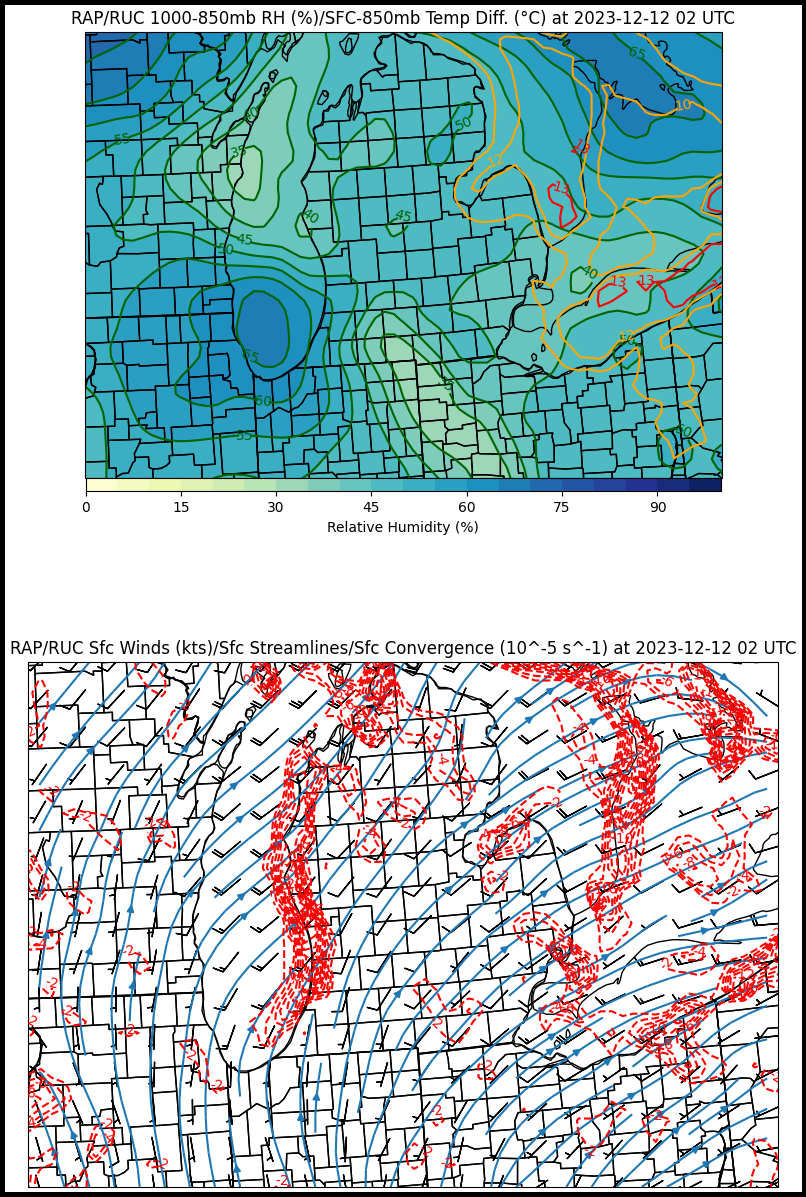

In [51]:
if variable == 'Synoptic 4-Panel':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(2,2,1,projection=mSLP.metpy.cartopy_crs)
  ax2=fig.add_subplot(2,2,2,projection=mSLP.metpy.cartopy_crs)
  ax3=fig.add_subplot(2,2,3,projection=mSLP.metpy.cartopy_crs)
  ax4=fig.add_subplot(2,2,4,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax2.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax3.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax4.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)
  ax2.set_box_aspect(0.7)
  ax3.set_box_aspect(0.7)
  ax4.set_box_aspect(0.7)


  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 250 mb Wind (kts)/Height (dam) at {year}-{month}-{day} {hour_utc} UTC')

  ax2.coastlines(color='black',resolution='10m',zorder=99)
  ax2.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax2.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax2.set_title(f'RAP/RUC 500 mb Wind (kts)/Height (dam)/Vorticity (10^-5 s^-1) at {year}-{month}-{day} {hour_utc} UTC')

  ax3.coastlines(color='black',resolution='10m',zorder=99)
  ax3.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax3.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax3.set_title(f'RAP/RUC 850 mb Wind (kts)/Height (dam)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC')

  ax4.coastlines(color='black',resolution='10m',zorder=99)
  ax4.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax4.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax4.set_title(f'RAP/RUC MSLP (hPa)/Wind (kts)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC')


  wind_fill = ax1.contourf(wind2.x,wind2.y,wind2, cmap='BuPu', levels=np.arange(60,201,20))
  plt.colorbar(wind_fill,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='Wind Speed (kts)', shrink = 0.91)
  ax1.barbs(u_wind2.x.values, u_wind2.y.values, u_wind2.values, v_wind2.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines2=ax1.contour(gph2select.x,gph2select.y,gph2select, colors='black', levels=np.arange(880,1180,6))
  ax1.clabel(gph_lines2,fmt='%4d', colors='black')

  gph_lines5=ax2.contour(gph5select.x,gph5select.y,gph5select, colors='black', levels=np.arange(420,660,6))
  ax2.clabel(gph_lines5,fmt='%4d', colors='black')

  vort_fill = ax2.contourf(abs_vort5.x, abs_vort5.y, abs_vort5, cmap = 'autumn_r', levels = np.arange(12,61, 4))
  plt.colorbar(vort_fill,orientation='horizontal',pad=0.0, aspect=50, label='Vorticity (10^-5 s^-1)', ax = ax2 , shrink = 0.91 )

  ax2.barbs(u_wind5.x.values, u_wind5.y.values, u_wind5.values, v_wind5.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines8=ax3.contour(gph8select.x,gph8select.y,gph8select, colors='black', levels=np.arange(12,252,3))
  ax3.clabel(gph_lines8,fmt='%4d', colors='black')

  temp_fill = ax3.contourf(T_UA8.x, T_UA8.y, T_UA8, cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(temp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax3 , shrink = 0.91)

  ax3.barbs(u_wind8.x.values, u_wind8.y.values, u_wind8.values, v_wind8.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  mSLP_lines=ax4.contour(mSLP.x, mSLP.y, mSLP, colors='black', levels=np.arange(960,1040,4))
  ax4.clabel(mSLP_lines,fmt='%4d', colors='black')

  sfctemp_fill = ax4.contourf(sfcTMP.x, sfcTMP.y, sfcTMP, cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(sfctemp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax4 , shrink = 0.91)

  ax4.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.values,sfc_v_wind.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  plt.savefig(f'SynopticAnalysis_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == '250 mb Analysis':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 250 mb Wind (kts)/Height (dam)/Divergence (10^-5 s^-1) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  wind_fill = ax1.contourf(wind2.x,wind2.y,wind2, cmap='BuPu', levels=np.arange(60,201,20))
  plt.colorbar(wind_fill,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='Wind Speed (kts)', shrink = 0.91)
  ax1.barbs(u_wind2.x.values, u_wind2.y.values, u_wind2.values, v_wind2.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines2=ax1.contour(gph2select.x,gph2select.y,gph2select, colors='black', levels=np.arange(880,1180,6))
  ax1.clabel(gph_lines2,fmt='%4d', colors='black')

  divlines = ax1.contour(h2div.x, h2div.y, h2div, colors = 'magenta', levels = [2,4,6,8,10,12,14])
  ax1.clabel(divlines, fmt = '%4d', colors = 'magenta')

  plt.savefig(f'250mbAnalysis_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == '500 mb Vorticity':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 500 mb Wind (kts)/Height (dam)/Vorticity (10^-5 s^-1) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  gph_lines5=ax1.contour(gph5select.x,gph5select.y,gph5select, colors='black', levels=np.arange(420,660,6))
  ax1.clabel(gph_lines5,fmt='%4d', colors='black')

  vort_fill = ax1.contourf(abs_vort5.x, abs_vort5.y, abs_vort5, cmap = 'autumn_r', levels = np.arange(12,61, 4))
  plt.colorbar(vort_fill,orientation='horizontal',pad=0.0, aspect=50, label='Vorticity (10^-5 s^-1)', ax = ax1 , shrink = 0.91 )

  ax1.barbs(u_wind5.x.values, u_wind5.y.values, u_wind5.values, v_wind5.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  plt.savefig(f'500mbVorticity_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == '500 mb Winds':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 500 mb Wind (kts)/Height (dam) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 30)

  wind_fill = ax1.contourf(wind5.x,wind5.y,wind5, cmap='BuPu', levels=np.arange(40,181,20))
  plt.colorbar(wind_fill,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='Wind Speed (kts)', shrink = 0.91)
  ax1.barbs(u_wind5.x.values, u_wind5.y.values, u_wind5.values, v_wind5.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines5=ax1.contour(gph5select.x,gph5select.y,gph5select, colors='black', levels=np.arange(420,660,6))
  ax1.clabel(gph_lines5,fmt='%4d', colors='black')

  plt.savefig(f'500mbWinds_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')


if variable == "850 mb Analysis 1":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 850 mb Wind (kts)/Height (dam)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  wind_fill = ax1.contourf(wind8.x,wind8.y,wind8, cmap='BuPu', levels=np.arange(20,76,5))
  plt.colorbar(wind_fill,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='Wind Speed (kts)', shrink = 0.91)
  ax1.barbs(u_wind8.x.values, u_wind8.y.values, u_wind8.values, v_wind8.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  gph_lines8=ax1.contour(gph8select.x,gph8select.y,gph8select, colors='black', levels=np.arange(12,252,3))
  ax1.clabel(gph_lines8,fmt='%4d', colors='black')

  subtemplines = ax1.contour(T_UA8.x, T_UA8.y, T_UA8, colors = ['blue'], levels = np.arange(-100,1,2), linestyle = '--')
  ax1.clabel(subtemplines,fmt='%2d', colors = ['blue'])

  plustemplines = ax1.contour(T_UA8.x, T_UA8.y, T_UA8, colors = ['red'], levels = np.arange(2,101,2))
  ax1.clabel(plustemplines,fmt='%2d', colors = ['red'])

  plt.savefig(f'850mbAnalysis1_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')


if variable == "850 mb Analysis 2":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 850 mb Wind (kts)/Height (dam)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  gph_lines8=ax1.contour(gph8select.x,gph8select.y,gph8select, colors='black', levels=np.arange(12,252,3))
  ax1.clabel(gph_lines8,fmt='%4d', colors='black')

  temp_fill = ax1.contourf(T_UA8.x, T_UA8.y, T_UA8, cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(temp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax1 , shrink = 0.91)

  ax1.barbs(u_wind8.x.values, u_wind8.y.values, u_wind8.values, v_wind8.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)
  subtemplines = ax1.contour(T_UA8.x, T_UA8.y, T_UA8, colors = ['blue'], levels = np.arange(-100,1,4), linestyle = '--')
  ax1.clabel(subtemplines,fmt='%2d', colors = ['blue'])

  plustemplines = ax1.contour(T_UA8.x, T_UA8.y, T_UA8, colors = ['red'], levels = np.arange(4,101,4))
  ax1.clabel(plustemplines,fmt='%2d', colors = ['red'])

  plt.savefig(f'850mbAnalysis2_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')


if variable == "Surface Temperature":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC Surface Wind (kts)/MSLP (hPa)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  mSLP_lines=ax1.contour(mSLP.x, mSLP.y, mSLP, colors='black', levels=np.arange(960,1040,4), linewidth=4)
  ax1.clabel(mSLP_lines,fmt='%4d', colors='black')

  sfctemp_fill = ax1.contourf(sfcTMP.x, sfcTMP.y, sfcTMP, cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(sfctemp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax1 , shrink = 0.91)

  ax1.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.values,sfc_v_wind.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  subtemplines = ax1.contour(sfcTMP.x, sfcTMP.y, sfcTMP, colors = ['blue'], levels = np.arange(-100,1,4), linestyle = '--')
  ax1.clabel(subtemplines,fmt='%2d', colors = ['blue'])

  plustemplines = ax1.contour(sfcTMP.x, sfcTMP.y, sfcTMP, colors = ['red'], levels = np.arange(4,101,4))
  ax1.clabel(plustemplines,fmt='%2d', colors = ['red'])

  plt.savefig(f'SurfaceTemperature_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')


if variable == "Surface Dewpoint":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC Surface Wind (kts)/MSLP (hPa)/Dewpoint (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  mSLP_lines=ax1.contour(mSLP.x, mSLP.y, mSLP, colors='black', levels=np.arange(960,1040,4), linewidth=4)
  ax1.clabel(mSLP_lines,fmt='%4d', colors='black')

  sfcdwpt_fill = ax1.contourf(sfcDPT.x, sfcDPT.y, sfcDPT, cmap = 'YlGnBu', levels = np.arange(-40,41, 4))
  plt.colorbar(sfcdwpt_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax1 , shrink = 0.91)

  ax1.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.values,sfc_v_wind.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)

  dwptlines = ax1.contour(sfcDPT.x, sfcDPT.y, sfcDPT, colors = ['darkgreen'], levels = np.arange(-40,41,4))
  ax1.clabel(dwptlines,fmt='%2d', colors = ['darkgreen'])

  plt.savefig(f'SurfaceDewpoint_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')


if variable == "Surface Pressure/Wind":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC Surface Wind (kts)/MSLP (hPa) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 30)

  mSLP_lines=ax1.contour(mSLP.x, mSLP.y, mSLP, colors='black', levels=np.arange(960,1040,4), linewidth=4)
  ax1.clabel(mSLP_lines,fmt='%4d', colors='black')

  ax1.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.values,sfc_v_wind.values, pivot='middle', color='black', regrid_shape=15, linewidth=1, length = 6)

  plt.savefig(f'SurfacePressure_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == "Precipitable Water":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC Surface Wind (kts)/MSLP (hPa)/Precipitable Water (in) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  mSLP_lines=ax1.contour(mSLP.x, mSLP.y, mSLP, colors='black', levels=np.arange(960,1040,4), linewidth=4)
  ax1.clabel(mSLP_lines,fmt='%4d', colors='black')

  pwat_fill = ax1.contourf(PWAT.x, PWAT.y, PWAT, cmap = 'YlGnBu', levels = np.arange(0,3,0.1))
  plt.colorbar(pwat_fill,orientation='horizontal',pad=0.0, aspect=50, label='Precipitable Water (in)', ax = ax1 , shrink = 0.91)

  pwatlines = ax1.contour(PWAT.x, PWAT.y, PWAT, colors = ['darkgreen'], levels = np.arange(0,3.1,0.25))
  ax1.clabel(pwatlines,fmt='%3.2f', colors = ['darkgreen'])

  ax1.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.values,sfc_v_wind.values, pivot='middle', color='black', regrid_shape=15, linewidth=1, length = 6)

  plt.savefig(f'PrecipitableWater_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == "925 mb Analysis ":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 925 mb Wind (kts)/Height (dam)/Temperature (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  gph_lines8=ax1.contour(gph9select.x,gph9select.y,gph9select, colors='black', levels=np.arange(15,135,3))
  ax1.clabel(gph_lines8,fmt='%4d', colors='black')

  temp_fill = ax1.contourf(T_UA9.x, T_UA9.y, T_UA9, cmap = 'jet', levels = np.arange(-40,41, 4))
  plt.colorbar(temp_fill,orientation='horizontal',pad=0.0, aspect=50, label='Temperature (°C)', ax = ax1 , shrink = 0.91)

  ax1.barbs(u_wind9.x.values, u_wind9.y.values, u_wind9.values, v_wind9.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)
  subtemplines = ax1.contour(T_UA9.x, T_UA9.y, T_UA9, colors = ['blue'], levels = np.arange(-100,1,4), linestyle = '--')
  ax1.clabel(subtemplines,fmt='%2d', colors = ['blue'])

  plustemplines = ax1.contour(T_UA9.x, T_UA9.y, T_UA9, colors = ['red'], levels = np.arange(4,101,4))
  ax1.clabel(plustemplines,fmt='%2d', colors = ['red'])

  plt.savefig(f'925mbAnalysis_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == "700 mb Analysis":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 700 mb Wind (kts)/Height (dam)/Temperature (°C)/Relative Humidity (%) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  gph_lines7=ax1.contour(gph7select.x,gph7select.y,gph7select, colors='black', levels=np.arange(0,600,3))
  ax1.clabel(gph_lines7,fmt='%4d', colors='black')

  rh_fill = ax1.contourf(RH7.x, RH7.y, RH7, cmap = 'YlGnBu', levels = np.arange(0,101, 5))
  plt.colorbar(rh_fill,orientation='horizontal',pad=0.0, aspect=50, label='Relative Humidity (%)', ax = ax1 , shrink = 0.91)

  ax1.barbs(u_wind7.x.values, u_wind7.y.values, u_wind7.values, v_wind7.values, pivot='middle', color='black', regrid_shape=15, linewidth=0.5, length = 5)
  subtemplines = ax1.contour(T_UA7.x, T_UA7.y, T_UA7, colors = ['blue'], levels = np.arange(-100,1,4), linestyle = '--')
  ax1.clabel(subtemplines,fmt='%2d', colors = ['blue'])

  plustemplines = ax1.contour(T_UA7.x, T_UA7.y, T_UA7, colors = ['red'], levels = np.arange(4,101,4))
  ax1.clabel(plustemplines,fmt='%2d', colors = ['red'])

  plt.savefig(f'700mbAnalysis_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == '4-Panel Frontogenesis':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(2,2,1,projection=mSLP.metpy.cartopy_crs)
  ax2=fig.add_subplot(2,2,2,projection=mSLP.metpy.cartopy_crs)
  ax3=fig.add_subplot(2,2,3,projection=mSLP.metpy.cartopy_crs)
  ax4=fig.add_subplot(2,2,4,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax2.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax3.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax4.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)
  ax2.set_box_aspect(0.7)
  ax3.set_box_aspect(0.7)
  ax4.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 500 mb Frontogenesis (K/100km/3hr) at {year}-{month}-{day} {hour_utc} UTC')

  ax2.coastlines(color='black',resolution='10m',zorder=99)
  ax2.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax2.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax2.set_title(f'RAP/RUC 700 mb Frontogenesis (K/100km/3hr) at {year}-{month}-{day} {hour_utc} UTC')

  ax3.coastlines(color='black',resolution='10m',zorder=99)
  ax3.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax3.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax3.set_title(f'RAP/RUC 850 mb Frontogenesis (K/100km/3hr) at {year}-{month}-{day} {hour_utc} UTC')

  ax4.coastlines(color='black',resolution='10m',zorder=99)
  ax4.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax4.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax4.set_title(f'925 mb Frontogenesis (K/100km/3hr) at {year}-{month}-{day} {hour_utc} UTC')

  fgen5cf = ax1.contourf(fgen_smooth5.x,fgen_smooth5.y,fgen_smooth5, cmap='viridis', levels=np.arange(1,11,1))
  plt.colorbar(fgen5cf,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='FGEN (K/100km/3hr))', shrink = 0.91)
  gph_lines5=ax1.contour(gph5select.x,gph5select.y,gph5select, colors='black', levels=np.arange(420,660, 6))
  ax1.clabel(gph_lines5,fmt='%4d', colors='black')

  fgen7cf = ax2.contourf(fgen_smooth7.x,fgen_smooth7.y,fgen_smooth7, cmap='viridis', levels=np.arange(1,11,1))
  plt.colorbar(fgen7cf,orientation='horizontal',pad=0.0, aspect=50, ax=ax2, label='FGEN (K/100km/3hr))', shrink = 0.91)
  gph_lines7=ax2.contour(gph7select.x,gph7select.y,gph7select, colors='black', levels=np.arange(0,600,3))
  ax2.clabel(gph_lines7,fmt='%4d', colors='black')

  fgen8cf = ax3.contourf(fgen_smooth8.x,fgen_smooth8.y,fgen_smooth8, cmap='viridis', levels=np.arange(1,11,1))
  plt.colorbar(fgen8cf,orientation='horizontal',pad=0.0, aspect=50, ax=ax3, label='FGEN (K/100km/3hr))', shrink = 0.91)
  gph_lines8=ax3.contour(gph8select.x,gph8select.y,gph8select, colors='black', levels=np.arange(12,252,3))
  ax3.clabel(gph_lines8,fmt='%4d', colors='black')

  fgen9cf = ax4.contourf(fgen_smooth9.x,fgen_smooth9.y,fgen_smooth9, cmap='viridis', levels=np.arange(1,11,1))
  plt.colorbar(fgen9cf,orientation='horizontal',pad=0.0, aspect=50, ax=ax4, label='FGEN (K/100km/3hr))', shrink = 0.91)
  gph_lines9=ax4.contour(gph9select.x,gph9select.y,gph9select, colors='black', levels=np.arange(15,135,3))
  ax4.clabel(gph_lines9,fmt='%4d', colors='black')

  plt.savefig(f'FGEN4Panel_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == '500 mb Frontogenesis':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)
  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 500 mb Frontogenesis (K/100km/3hr) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  fgen5cf = ax1.contourf(fgen_smooth5.x,fgen_smooth5.y,fgen_smooth5, cmap='viridis', levels=np.arange(1,11,1))
  plt.colorbar(fgen5cf,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='FGEN (K/100km/3hr))', shrink = 0.91)
  gph_lines5=ax1.contour(gph5select.x,gph5select.y,gph5select, colors='black', levels=np.arange(420,660, 6))
  ax1.clabel(gph_lines5,fmt='%4d', colors='black')

  plt.savefig(f'FGEN500mb_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == '700 mb Frontogenesis':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)
  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)


  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 700 mb Frontogenesis (K/100km/3hr) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  fgen7cf = ax1.contourf(fgen_smooth7.x,fgen_smooth7.y,fgen_smooth7, cmap='viridis', levels=np.arange(1,11,1))
  plt.colorbar(fgen7cf,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='FGEN (K/100km/3hr))', shrink = 0.91)
  gph_lines7=ax1.contour(gph7select.x,gph7select.y,gph7select, colors='black', levels=np.arange(0,600,3))
  ax1.clabel(gph_lines7,fmt='%4d', colors='black')

  plt.savefig(f'FGEN700mb_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == '850 mb Frontogenesis':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)
  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 850 mb Frontogenesis (K/100km/3hr) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  fgen8cf = ax1.contourf(fgen_smooth8.x,fgen_smooth8.y,fgen_smooth8, cmap='viridis', levels=np.arange(1,11,1))
  plt.colorbar(fgen8cf,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='FGEN (K/100km/3hr))', shrink = 0.91)
  gph_lines8=ax1.contour(gph8select.x,gph8select.y,gph5select, colors='black', levels=np.arange(12,252,3))
  ax1.clabel(gph_lines8,fmt='%4d', colors='black')

  plt.savefig(f'FGEN850mb_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == '925 mb Frontogenesis':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)
  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)


  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 925 mb Frontogenesis (K/100km/3hr) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  fgen9cf = ax1.contourf(fgen_smooth9.x,fgen_smooth9.y,fgen_smooth9, cmap='viridis', levels=np.arange(1,11,1))
  plt.colorbar(fgen9cf,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='FGEN (K/100km/3hr))', shrink = 0.91)
  gph_lines9=ax1.contour(gph9select.x,gph9select.y,gph9select, colors='black', levels=np.arange(15,135,3))
  ax1.clabel(gph_lines9,fmt='%4d', colors='black')

  plt.savefig(f'FGEN925mb_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == 'CAPE/Shear':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)
  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC SFC CAPE/CIN (J/kg) / SFC-500mb Shear (kts) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  capelines = ax1.contour(sfccape.x,sfccape.y,sfccape, colors = ['red','red','red','red','red','red','red','#a30000','#a30000','#ff00c8','#ff00c8','#ff00c8', '#ff00c8','#ff00c8','#ff00c8', '#ff00c8','#ff00c8'],
                          linewidths = [1.,1.,1.,1.,1.,1.,1.,2.,2.,3.,3.,3., 3.,3.,3.],
                          levels=[0,250,500,750,1000,1250,1500,1750,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500])
  ax1.clabel(capelines,fmt='%4d', colors=['red','red','red','red','red','red','red','#a30000','#a30000','#ff00c8','#ff00c8','#ff00c8','#ff00c8','#ff00c8','#ff00c8'])
  cin = ax1.contourf(sfccin.x, sfccin.y, sfccin, colors = ['#0f9bab','#36cfe0'], levels = [-1000,-100,-25], alpha = 0.4)
  plt.colorbar(cin,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='CIN (J/Kg)', shrink = 0.91)
  ax1.barbs(u_shear.x.values, u_shear.y.values, u_shear.values, v_shear.values, pivot='middle', color='black', regrid_shape=15, linewidth=1, length = 8, zorder = 9)

  plt.savefig(f'CAPEShear_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == "1000-700 mb RH":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 1000-700 mb RH (%)/850 mb Heights at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  gph_lines7=ax1.contour(gph7select.x,gph7select.y,gph7select, colors='black', levels=np.arange(12,252,3))
  ax1.clabel(gph_lines7,fmt='%4d', colors='black')

  rh_fill = ax1.contourf(RH107_Mean.x, RH107_Mean.y, RH107_Mean, cmap = 'YlGnBu', levels = np.arange(0,101, 5))
  plt.colorbar(rh_fill,orientation='horizontal',pad=0.0, aspect=50, label='Relative Humidity (%)', ax = ax1 , shrink = 0.91)

  rhlines = ax1.contour(RH107_Mean.x, RH107_Mean.y,RH107_Mean, colors = ['darkgreen'], levels = np.arange(0,101,5))
  ax1.clabel(rhlines,fmt='%2d', colors = ['white'])

  plt.savefig(f'H10H7RH_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == 'CAPE/0-1km SRH':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)
  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC SFC CAPE/CIN (J/kg) / 0-1km SRH (m^2 s^-2) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  capelines = ax1.contour(sfccape.x,sfccape.y,sfccape, colors = ['red','red','red','red','red','red','red','#a30000','#a30000','#ff00c8','#ff00c8','#ff00c8', '#ff00c8','#ff00c8','#ff00c8', '#ff00c8','#ff00c8'],
                          linewidths = [1.,1.,1.,1.,1.,1.,1.,2.,2.,3.,3.,3., 3.,3.,3.],
                          levels=[0,250,500,750,1000,1250,1500,1750,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500])
  ax1.clabel(capelines,fmt='%4d', colors=['red','red','red','red','red','red','red','#a30000','#a30000','#ff00c8','#ff00c8','#ff00c8','#ff00c8','#ff00c8','#ff00c8'])
  srhshade = ax1.contourf(SRH1.x, SRH1.y, SRH1, cmap = 'viridis', levels = np.arange(50,650,50), extend = 'max', alpha = 0.4)
  plt.colorbar(srhshade,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='SRH (m^2 s^-2)', shrink = 0.91)

  plt.savefig(f'CAPESRH01_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == 'CAPE/0-3km SRH':
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)
  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])
  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC SFC CAPE/CIN (J/kg) / 0-3km SRH (m^2 s^-2) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  capelines = ax1.contour(sfccape.x,sfccape.y,sfccape, colors = ['red','red','red','red','red','red','red','#a30000','#a30000','#ff00c8','#ff00c8','#ff00c8', '#ff00c8','#ff00c8','#ff00c8', '#ff00c8','#ff00c8'],
                          linewidths = [1.,1.,1.,1.,1.,1.,1.,2.,2.,3.,3.,3., 3.,3.,3.],
                          levels=[0,250,500,750,1000,1250,1500,1750,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500])
  ax1.clabel(capelines,fmt='%4d', colors=['red','red','red','red','red','red','red','#a30000','#a30000','#ff00c8','#ff00c8','#ff00c8','#ff00c8','#ff00c8','#ff00c8'])
  srhshade = ax1.contourf(SRH3.x, SRH3.y, SRH3, cmap = 'viridis', levels = np.arange(50,650,50), extend = 'max', alpha = 0.4)
  plt.colorbar(srhshade,orientation='horizontal',pad=0.0, aspect=50, ax=ax1, label='SRH (m^2 s^-2)', shrink = 0.91)

  plt.savefig(f'CAPESRH03_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == "700-500 mb Lapse Rates":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 700-500 mb Lapse Rate (°C/km) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  LR_lines=ax1.contour(LR75.x, LR75.y, LR75, colors='black', levels=np.arange(5,10.50,0.5), linewidth=4)
  ax1.clabel(LR_lines,fmt='%4d', colors='black')

  LR_fill = ax1.contourf(LR75.x, LR75.y, LR75, cmap = 'autumn_r', levels = np.arange(5,10.50,0.5))
  plt.colorbar(LR_fill,orientation='horizontal',pad=0.0, aspect=50, label='Lapse Rate (°C/km)', ax = ax1 , shrink = 0.91)

  plt.savefig(f'H7H5LapseRate_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == "SFC-700 mb Lapse Rates":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC SFC-700 mb Lapse Rate (°C/km) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  LR_lines=ax1.contour(LRS7.x, LRS7.y, LRS7, colors='black', levels=np.arange(5,10.50,0.5), linewidth=4)
  ax1.clabel(LR_lines,fmt='%4d', colors='black')

  LR_fill = ax1.contourf(LRS7.x, LRS7.y, LRS7, cmap = 'autumn_r', levels = np.arange(5,10.50,0.5))
  plt.colorbar(LR_fill,orientation='horizontal',pad=0.0, aspect=50, label='Lapse Rate (°C/km)', ax = ax1 , shrink = 0.91)

  plt.savefig(f'SFCH7LapseRate_{year}{month}{day}{hour_utc}', bbox_inches = 'tight')

if variable == "Lake Effect Snow 1":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 1000-850mb RH (%)/SFC-850mb Temp Diff. (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 25)

  rh_fill = ax1.contourf(RH108_Mean.x, RH108_Mean.y, RH108_Mean, cmap = 'YlGnBu', levels = np.arange(0,101, 5))
  plt.colorbar(rh_fill,orientation='horizontal',pad=0.0, aspect=50, label='Relative Humidity (%)', ax = ax1 , shrink = 0.91)

  rhlines = ax1.contour(RH108_Mean.x, RH108_Mean.y,RH108_Mean, colors = ['darkgreen'], levels = np.arange(0,101,5))
  ax1.clabel(rhlines,fmt='%2d', colors = ['darkgreen'])

  templines = ax1.contour(sfch8tdiff.x, sfch8tdiff.y, sfch8tdiff, colors = ['orange', 'orange', 'red', 'red', 'red', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink'], levels = [10,12,13,14,16,18,20,22, 24, 26, 28, 30])
  ax1.clabel(templines,fmt='%2d', colors = ['orange', 'orange', 'red', 'red', 'red', 'pink', 'pink', 'pink'])

if variable == "Lake Effect Snow 2":
  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(1,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC Sfc Winds (kts)/Sfc Streamlines/Sfc Convergence (10^-5 s^-1) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 20)

  strmlns = ax1.streamplot(sfc_u_wind.x, sfc_u_wind.y, sfc_u_wind, sfc_v_wind)

  conlines =  ax1.contour(sfcdiv.x, sfcdiv.y, sfcdiv, colors = 'red', levels = np.arange(-30, -1, 2))
  ax1.clabel (conlines, colors = 'red', fmt = '%2d')
  ax1.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.values,sfc_v_wind.values, pivot='middle', color='black', regrid_shape=15, linewidth=1, length = 6)

if variable == "Lake Effect Snow 2-Panel":

  fig = plt.figure(figsize=(20,15), edgecolor="black", linewidth =6)

  ax1=fig.add_subplot(2,1,1,projection=mSLP.metpy.cartopy_crs)

  ax1.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax1.set_box_aspect(0.7)

  ax1.coastlines(color='black',resolution='10m',zorder=99)
  ax1.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax1.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax1.set_title(f'RAP/RUC 1000-850mb RH (%)/SFC-850mb Temp Diff. (°C) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 12)

  rh_fill = ax1.contourf(RH108_Mean.x, RH108_Mean.y, RH108_Mean, cmap = 'YlGnBu', levels = np.arange(0,101, 5))
  plt.colorbar(rh_fill,orientation='horizontal',pad=0.0, aspect=50, label='Relative Humidity (%)', ax = ax1 , shrink = 0.41)

  rhlines = ax1.contour(RH108_Mean.x, RH108_Mean.y,RH108_Mean, colors = ['darkgreen'], levels = np.arange(0,101,5))
  ax1.clabel(rhlines,fmt='%2d', colors = ['darkgreen'])

  templines = ax1.contour(sfch8tdiff.x, sfch8tdiff.y, sfch8tdiff, colors = ['orange', 'orange', 'red', 'red', 'red', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink'], levels = [10,12,13,14,16,18,20,22, 24, 26, 28, 30])
  ax1.clabel(templines,fmt='%2d', colors = ['orange', 'orange', 'red', 'red', 'red', 'pink', 'pink', 'pink'])

  ax2=fig.add_subplot(2,1,2,projection=mSLP.metpy.cartopy_crs)

  ax2.set_extent([WestLong, EastLong, SouthLat, NorthLat])

  ax2.set_box_aspect(0.7)

  ax2.coastlines(color='black',resolution='10m',zorder=99)
  ax2.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black')
  ax2.add_feature(USCOUNTIES, facecolor='None', edgecolor='black')

  ax2.set_title(f'RAP/RUC Sfc Winds (kts)/Sfc Streamlines/Sfc Convergence (10^-5 s^-1) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 12)

  strmlns = ax2.streamplot(sfc_u_wind.x, sfc_u_wind.y, sfc_u_wind, sfc_v_wind)

  conlines =  ax2.contour(sfcdiv.x, sfcdiv.y, sfcdiv, colors = 'red', levels = np.arange(-30, -1, 2))
  ax2.clabel (conlines, colors = 'red', fmt = '%2d')
  ax2.barbs(sfc_u_wind.x.values, sfc_u_wind.y.values, sfc_u_wind.values,sfc_v_wind.values, pivot='middle', color='black', regrid_shape=15, linewidth=1, length = 6)
